# Simpson Characters Recognition

Download
[Kaggle-The Simpsons Characters Data](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset/)
![simpson](https://imgur.com/3EwxzYC.png)

## Data set description

simpsons_dataset.tar.gz: training data. Full dataset : 20 characters, see number_pic_char.csv for mor details.
kaggle_simpson_testset.zip: testing data. 900 picture to show the content of the dataset
weights.best.hdf5: Weights to predict characters in Kernels
annotation.txt: characters bounding box coordinates. 



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import glob
import time
from random import shuffle
from collections import Counter

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


## Data Preprocessing

The first step for preprocessing pictures is resizing them. We need to have all pictures with the same size for training. I will convert data as float32 to save some memory and normalize them (divide by 255.). Then, instead of characters name, I use numbers and thanks to Keras, I can quickly convert those categories to vectors :

In [10]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

img_width = 42 
img_height = 42

num_classes = len(map_characters) 

# Each character will have nearly 1000 training images
pictures_per_class = 1000 
test_size = 0.15

imgsPath = "D:/Program/dataset/the-simpsons-characters-dataset/train"
path = "D:/Program/dataset/the-simpsons-characters-dataset/"

In [11]:
def load_pictures():
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """ 
    pics = []
    labels = []
    
    # k: number encoding, v: role label
    for k, v in map_characters.items(): 
        pictures = [r for r in glob.glob(imgsPath + "/" + v + "/*")]        
        print(v + " : " + str(len(pictures))) 
        for i, pic in enumerate(pictures):
            tmp_img = cv2.imread(pic)
            
            # Since OpenCv reads BGR (Blue-Green-Red), we turn it into RGB (Red-Green-Blue)
            tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB)
            tmp_img = cv2.resize(tmp_img, (img_height, img_width))             
            pics.append(tmp_img)
            labels.append(k)    
    return np.array(pics), np.array(labels)

In [12]:
def get_dataset(save=False, load=False):
    """
    Create the actual dataset split into train and test, pictures content is as float32 and
    normalized (/255.). The dataset could be saved or loaded from h5 files.
    :param save: saving or not the created dataset
    :param load: loading or not the dataset
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: X_train, X_test, y_train, y_test (numpy arrays)
    """
    if load: 
        # Processed saved training and validation data sets before loading from the file system
        h5f = h5py.File(path+'dataset.h5','r')
        X_train = h5f['X_train'][:]
        X_test = h5f['X_test'][:]
        h5f.close()
        
        # Processing saved training and validation datalabels from the file system
        h5f = h5py.File(path+'labels.h5', 'r')
        y_train = h5f['y_train'][:]
        y_test = h5f['y_test'][:]
        h5f.close()
    
    else:
        
        X, y = load_pictures()
        # one-hot encoding
        y = keras.utils.to_categorical(y, num_classes) 
        
        # The data is divided into training data sets and validation data sets (85% vs. 15%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 
        
        if save: 
            h5f = h5py.File(path+'dataset.h5', 'w')
            h5f.create_dataset('X_train', data=X_train)
            h5f.create_dataset('X_test', data=X_test)
            h5f.close()
            
            h5f = h5py.File(path+'labels.h5', 'w')
            h5f.create_dataset('y_train', data=y_train)
            h5f.create_dataset('y_test', data=y_test)
            h5f.close()
    
    # normalized
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    print("Train", X_train.shape, y_train.shape)
    print("Test", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = get_dataset(save=True, load=False)

abraham_grampa_simpson : 913
apu_nahasapeemapetilon : 623
bart_simpson : 1342
charles_montgomery_burns : 1193
chief_wiggum : 986
comic_book_guy : 469
edna_krabappel : 457
homer_simpson : 2246
kent_brockman : 498
krusty_the_clown : 1206
lisa_simpson : 1354
marge_simpson : 1291
milhouse_van_houten : 1079
moe_szyslak : 1452
ned_flanders : 1454
nelson_muntz : 358
principal_skinner : 1194
sideshow_bob : 877
Train (16143, 42, 42, 3) (16143, 18)
Test (2849, 42, 42, 3) (2849, 18)


In [18]:
def create_model_six_conv(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# image shape is (42,42,3)
model = create_model_six_conv((img_height, img_width, 3)) 

model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 42, 42, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 64)          0         
__________

In [19]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

## Training

Add some features to our training settings:
* Learning rate scheduler: Declining the weight-adjusted learning rate as the number of training cycles increases generally helps to make the model learn better

* Model checkpoint: We will compare the verification accuracy for each training cycle and save only the model with the best model performance. This is a useful setting for depth proficiency because our network may start to overfitting after a certain number of training cycles, but we need to stay with the best performing model throughout training.

These settings are not necessary, but they do improve the accuracy of the model. These features are implemented via Keras callback functionality. The callback is a set of functions that will be applied at a specific stage of the training process, such as ending the training. Keras provides built-in [learning rate scheduling](https://keras.io/callbacks/#learningratescheduler) and [model checkpointing](https://keras.io/callbacks/#modelcheckpoint).

In [20]:
lr = 0.01
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
epochs = 30

history = model.fit(X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_test, y_test),
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint(path+'model.h5', save_best_only=True)
         ])

Train on 16143 samples, validate on 2849 samples
Epoch 1/30
16143/16143 [==============================] - 17s 1ms/step - loss: 2.6789 - acc: 0.1603 - val_loss: 2.2511 - val_acc: 0.3026
Epoch 2/30
16143/16143 [==============================] - 14s 849us/step - loss: 1.9639 - acc: 0.3900 - val_loss: 1.6064 - val_acc: 0.5156
Epoch 3/30
16143/16143 [==============================] - 14s 866us/step - loss: 1.3808 - acc: 0.5748 - val_loss: 1.1055 - val_acc: 0.6750
Epoch 4/30
16143/16143 [==============================] - 14s 848us/step - loss: 1.0723 - acc: 0.6751 - val_loss: 0.8985 - val_acc: 0.7417
Epoch 5/30
16143/16143 [==============================] - 14s 854us/step - loss: 0.9032 - acc: 0.7254 - val_loss: 0.7600 - val_acc: 0.7666
Epoch 6/30
16143/16143 [==============================] - 14s 849us/step - loss: 0.7525 - acc: 0.7688 - val_loss: 0.6665 - val_acc: 0.8069
Epoch 7/30
16143/16143 [==============================] - 14s 838us/step - loss: 0.6689 - acc: 0.7937 - val_loss: 0.569

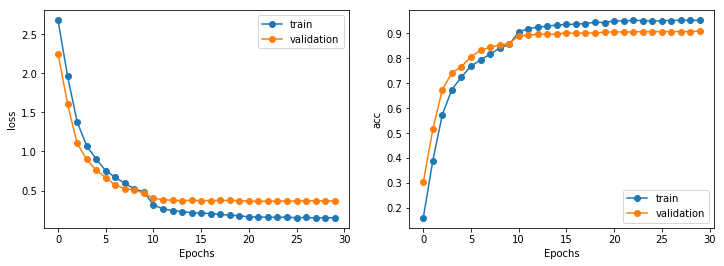

In [21]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()

In [22]:
### Evaluation ###

import os
from pathlib import PurePath


def load_test_set(path):
    pics, labels = [], []
    reverse_dict = {v:k for k,v in map_characters.items()}
    for pic in glob.glob(path+'*.jpg'):
        char_name = "_".join(os.path.basename(pic).split('_')[:-1])
        if char_name in reverse_dict:
            temp = cv2.imread(pic)
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            temp = cv2.resize(temp, (img_height,img_width)).astype('float32') / 255.
            pics.append(temp)
            labels.append(reverse_dict[char_name])
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = keras.utils.to_categorical(y_test, num_classes) 
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test

imgsPath = "D:/Program/dataset/the-simpsons-characters-dataset/test/"

X_valtest, y_valtest = load_test_set(imgsPath)

Test set (890, 42, 42, 3) (890, 18)


In [23]:
# Prediction and comparison
from keras.models import load_model

# Load the model with the smallest val_loss during training
model = load_model(path+'model.h5')

y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred==np.argmax(y_valtest, axis=1))/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9719101123595506


# Data Augmentation

In [24]:
from keras.preprocessing.image import ImageDataGenerator

datagen = datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(X_train)
filepath = path+"model-dtaug.h5"

# Keep the best val_acc model
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

model = create_model_six_conv((img_height, img_width, 3)) 

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

callbacks_list = [LearningRateScheduler(lr_schedule) ,checkpoint]
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=callbacks_list)

Epoch 1/30
504/504 [==============================] - 18s 36ms/step - loss: 2.6723 - acc: 0.1602 - val_loss: 2.3277 - val_acc: 0.2952
Epoch 2/30
504/504 [==============================] - 16s 32ms/step - loss: 2.2176 - acc: 0.3124 - val_loss: 1.7304 - val_acc: 0.4770
Epoch 3/30
504/504 [==============================] - 16s 32ms/step - loss: 1.7300 - acc: 0.4630 - val_loss: 1.3463 - val_acc: 0.5820
Epoch 4/30
504/504 [==============================] - 16s 32ms/step - loss: 1.3818 - acc: 0.5712 - val_loss: 0.9717 - val_acc: 0.7146
Epoch 5/30
504/504 [==============================] - 17s 33ms/step - loss: 1.1415 - acc: 0.6491 - val_loss: 0.8493 - val_acc: 0.7445
Epoch 6/30
504/504 [==============================] - 17s 34ms/step - loss: 0.9686 - acc: 0.7094 - val_loss: 0.6807 - val_acc: 0.7922
Epoch 7/30
504/504 [==============================] - 16s 32ms/step - loss: 0.8670 - acc: 0.7381 - val_loss: 0.6646 - val_acc: 0.8048
Epoch 8/30
504/504 [==============================] - 16s 32ms

In [25]:
from keras.models import load_model

model = load_model(path+'model-dtaug.h5')

y_pred = model.predict_classes(X_valtest)
acc = np.sum(y_pred==np.argmax(y_valtest, axis=1))/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9348314606741573


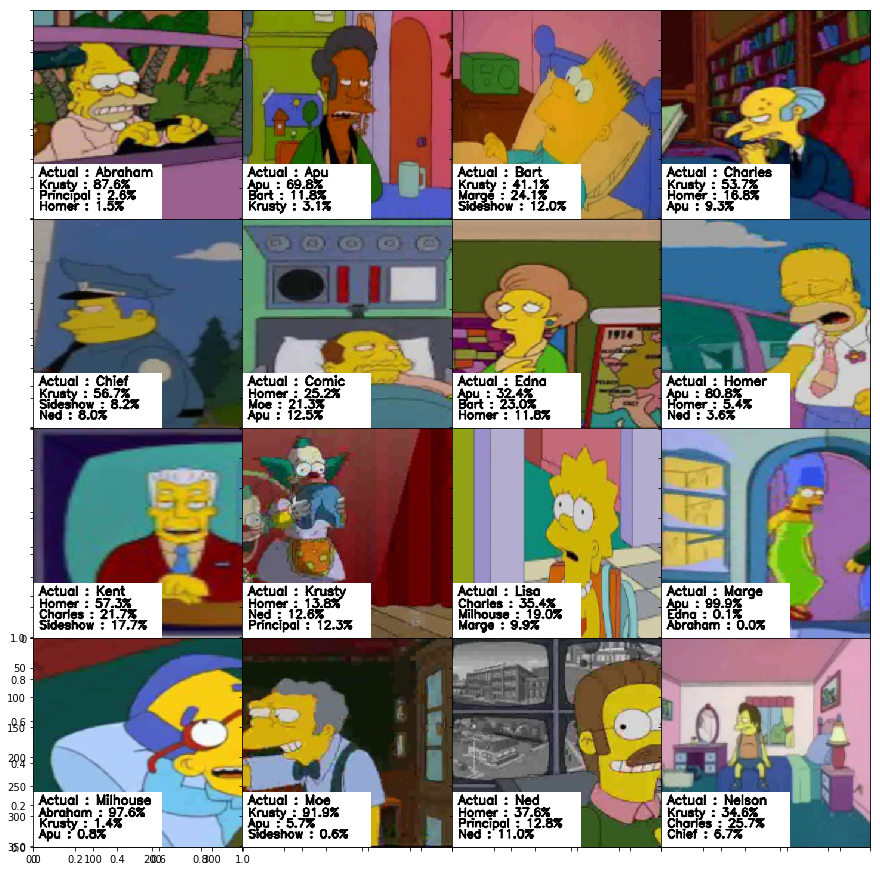

In [27]:
from mpl_toolkits.axes_grid1 import AxesGrid

model = load_model(path+'model.h5')

F = plt.figure(1, (15,20))
grid = AxesGrid(F, 111, nrows_ncols=(4, 4), axes_pad=0, label_mode="1")

for i in range(16):
    char = map_characters[i]
    image = cv2.imread(np.random.choice([k for k in glob.glob(path+'test/*.jpg') if char in k]))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pic = cv2.resize(image, (42, 42)).astype('float32') / 255.
    a = model.predict(pic.reshape(1, 42, 42,3))[0]
    actual = char.split('_')[0].title()
    text = sorted(['{:s} : {:.1f}%'.format(map_characters[k].split('_')[0].title(), 100*v) for k,v in enumerate(a)], 
       key=lambda x:float(x.split(':')[1].split('%')[0]), reverse=True)[:3]
    img = cv2.resize(img, (352, 352))
    cv2.rectangle(img, (0,260),(215,352),(255,255,255), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Actual : %s' % actual, (10, 280), font, 0.7,(0,0,0),2,cv2.LINE_AA)
    for k, t in enumerate(text):
        cv2.putText(img, t,(10, 300+k*18), font, 0.65,(0,0,0),2,cv2.LINE_AA)
    grid[i].imshow(img)
    
plt.show()

## The correct rate of prediction for each character

In [30]:
import sklearn

y_pred = model.predict(X_test)

print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.85      0.88       142
  apu_nahasapeemapetilon       0.91      0.95      0.93       103
            bart_simpson       0.88      0.82      0.85       214
charles_montgomery_burns       0.86      0.86      0.86       186
            chief_wiggum       0.91      0.91      0.91       151
          comic_book_guy       0.81      0.78      0.80        85
          edna_krabappel       0.83      0.79      0.81        68
           homer_simpson       0.89      0.91      0.90       334
           kent_brockman       0.90      1.00      0.95        75
        krusty_the_clown       0.96      0.94      0.95       182
            lisa_simpson       0.89      0.85      0.87       190
           marge_simpson       0.94      0.98      0.96       203
     milhouse_van_houten       0.95      0.93      0.94       150
             moe_szyslak       0.91      0.93      0.92       193
        

## Confusion matrix visualization

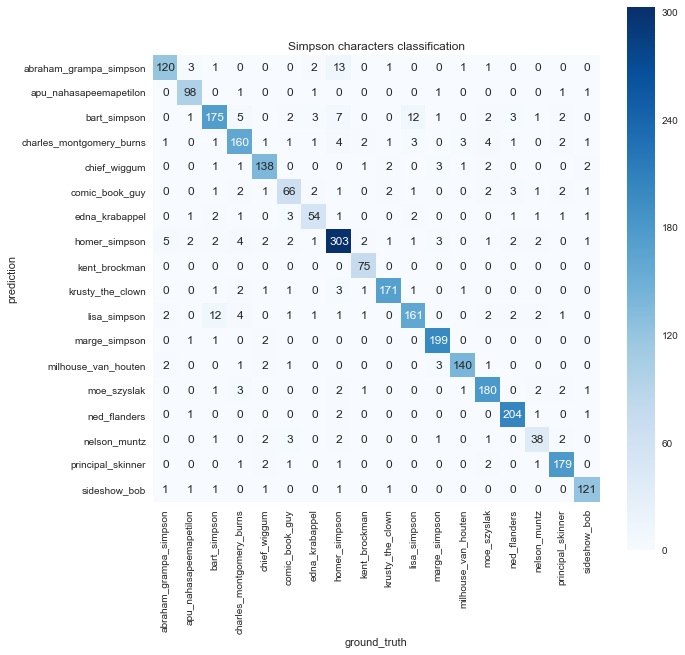

In [31]:
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
df = pd.DataFrame(conf_mat, index=classes, columns=classes)

fig = plt.figure(figsize = (10,10))
sns.heatmap(df, annot=True, square=True, fmt='.0f', cmap="Blues")
plt.title('Simpson characters classification')
plt.xlabel('ground_truth')
plt.ylabel('prediction')

plt.show()

We can see that some of the characters are mixed with their characters:

* Abraham: He was confused with Homer (his son), this is normal, his son looks like Daddy.
* Bart: He mixed up with Lisa (his sister) probably because they had some common photos: maybe we need to clean up a little data set.

Data Augmentation in this training did not make model efficiency, and may need to increase the training cycle

## Reference:

[The Simpsons characters recognition and detection using Keras (Part 1)](https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36)